In [4]:
import pandas as pd

# 1. Define the filename (make sure you renamed it!)
file_path = 'crsp_stock_returns_1985_2024.csv' # Or the new name if you renamed it

# 2. Read only the first 5 rows to see the columns
df_preview = pd.read_csv(file_path, nrows=5)

# 3. Show the columns and the first few rows
print("Columns in the file:")
print(df_preview.columns.tolist())

print("\nFirst 5 rows of data:")
display(df_preview)

Columns in the file:
['PERMNO', 'date', 'NAMEENDT', 'SHRCD', 'EXCHCD', 'SICCD', 'NCUSIP', 'TICKER', 'COMNAM', 'SHRCLS', 'TSYMBOL', 'NAICS', 'PRIMEXCH', 'TRDSTAT', 'SECSTAT', 'PERMCO', 'ISSUNO', 'HEXCD', 'HSICCD', 'CUSIP', 'DCLRDT', 'DLAMT', 'DLPDT', 'DLSTCD', 'NEXTDT', 'PAYDT', 'RCRDDT', 'SHRFLG', 'HSICMG', 'HSICIG', 'DISTCD', 'DIVAMT', 'FACPR', 'FACSHR', 'ACPERM', 'ACCOMP', 'SHRENDDT', 'NWPERM', 'DLRETX', 'DLPRC', 'DLRET', 'TRTSCD', 'NMSIND', 'MMCNT', 'NSDINX', 'BIDLO', 'ASKHI', 'PRC', 'VOL', 'RET', 'BID', 'ASK', 'SHROUT', 'CFACPR', 'CFACSHR', 'ALTPRC', 'SPREAD', 'ALTPRCDT', 'RETX', 'vwretd', 'vwretx', 'ewretd', 'ewretx', 'sprtrn']

First 5 rows of data:


,PERMNO,date,NAMEENDT,SHRCD,EXCHCD,SICCD,NCUSIP,TICKER,COMNAM,SHRCLS,...,CFACSHR,ALTPRC,SPREAD,ALTPRCDT,RETX,vwretd,vwretx,ewretd,ewretx,sprtrn
0,10000,1985-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-2.5625,NaN,1986-01-07,NaN,0.043061,0.040080,0.028021,0.026355,0.045061
1,10000,1986-01-31,1986-12-03,10.0,3.0,3990.0,68391610.0,OMFGA,OPTIMUM MANUFACTURING INC,A,...,1.0,-4.3750,0.250,1986-01-31,C,0.009830,0.008007,0.044071,0.043082,0.002367
2,10000,1986-02-28,NaN,10.0,3.0,3990.0,68391610.0,OMFGA,OPTIMUM MANUFACTURING INC,A,...,1.0,-3.2500,0.250,1986-02-28,-0.257143,0.072501,0.068191,0.060381,0.058938,0.071489
3,10000,1986-03-31,NaN,10.0,3.0,3990.0,68391610.0,OMFGA,OPTIMUM MANUFACTURING INC,A,...,1.0,-4.4375,0.125,1986-03-31,0.365385,0.053887,0.051362,0.047192,0.045679,0.052794
4,10000,1986-04-30,NaN,10.0,3.0,3990.0,68391610.0,OMFGA,OPTIMUM MANUFACTURING INC,A,...,1.0,-4.0000,0.250,1986-04-30,-0.098592,-0.007903,-0.009634,0.016140,0.015141,-0.014148


In [6]:
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [10]:
# data cleaning things..
raw = pd.read_excel("data_gpr_export.xls")
df = raw[["month", "GPR"]].copy()
df["month"] = pd.to_datetime(df["month"], dayfirst=True, errors="coerce")
df = df.dropna(subset=["month", "GPR"]).sort_values("month").reset_index(drop=True)

# Make month the index 
df = df.set_index("month")
# definition simple difference shock: GPR_t - GPR_{t-1}
# here I just include a simple difference, to compare the AR to something
df["gpr_change"] = df["GPR"].diff()

# 2) AR(1): GPR_t = c + phi * GPR_{t-1} + u_t
gpr = df["GPR"]
gpr_lag = gpr.shift(1)

df["gpr_ar1_pred"] = np.nan
df["gpr_news_shock"] = np.nan


# Start once we have enough data to estimate, for the AR(1)
# Keep in mind we do not want to use future data to hedge ofc,
# Do we then use an expanding or moving window? Feel free to leave suggestions, gang
min_obs = 24 

for i in range(min_obs, len(df)):
    # Use data up to t-1 to fit AR(1)
    y_train = gpr.iloc[1:i]              
    x_train = gpr_lag.iloc[1:i]          
    train = pd.concat([y_train, x_train], axis=1).dropna()

    y = train.iloc[:, 0]
    x = sm.add_constant(train.iloc[:, 1])

    model = sm.OLS(y, x).fit()

    # One-step-ahead prediction for time t
    x_t = sm.add_constant(pd.Series([gpr_lag.iloc[i]], index=["x"]), has_constant="add")
    # Align names to model params
    x_t = pd.DataFrame({"const": [1.0], train.columns[1]: [gpr_lag.iloc[i]]})

    gpr_hat_t = float(model.predict(x_t)[0])
    shock_t = float(gpr.iloc[i] - gpr_hat_t)

    df.iloc[i, df.columns.get_loc("gpr_ar1_pred")] = gpr_hat_t
    df.iloc[i, df.columns.get_loc("gpr_news_shock")] = shock_t

# Standardize shocks (z-scores)
df["gpr_change_z"] = (df["gpr_change"] - df["gpr_change"].mean()) / df["gpr_change"].std()
df["gpr_news_shock_z"] = (df["gpr_news_shock"] - df["gpr_news_shock"].mean()) / df["gpr_news_shock"].std()

# columns:
# gpr_news_shock   : AR(1) innovation in GPR (raw)
# gpr_news_shock_z : standardized AR(1) GPR shock
# gpr_change      : month-to-month change in GPR
# gpr_change_z    : standardized change in GPR
df

,GPR,gpr_change,gpr_ar1_pred,gpr_news_shock,gpr_change_z,gpr_news_shock_z
month,,,,,,
1985-01-01,102.173378,NaN,NaN,NaN,NaN,NaN
1985-02-01,117.102020,14.928642,NaN,NaN,0.420577,NaN
1985-03-01,124.778152,7.676132,NaN,NaN,0.215553,NaN
1985-04-01,87.929001,-36.849152,NaN,NaN,-1.043155,NaN
1985-05-01,103.262848,15.333847,NaN,NaN,0.432032,NaN
...,...,...,...,...,...,...
2025-08-01,136.759415,1.755157,126.131691,10.627724,0.048170,0.321744
2025-09-01,124.114983,-12.644432,127.436132,-3.321149,-0.358899,-0.084686
2025-10-01,154.425201,30.310219,118.259686,36.165515,0.855407,1.065841


In [59]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import MonthEnd
from pandas_datareader import data as web

# --- 1. Load & Clean Stock Data (The "Samuel + Pro" Version) ---
print("Loading and cleaning stock data...")

# We ADD 'shrcd' to the columns we need to load
cols_needed = ['permno', 'date', 'ret', 'prc', 'shrout', 'siccd', 'dlret', 'shrcd']
file_path = 'crsp_stock_returns_1985_2024.csv' 

df_stocks_clean = pd.read_csv(
    file_path, 
    usecols=lambda x: x.lower() in cols_needed, 
    low_memory=False
)
df_stocks_clean.columns = df_stocks_clean.columns.str.lower()

# --- SAMUEL'S FILTER: Keep only Common Shares (10 & 11) ---
print(f"Rows before filter: {len(df_stocks_clean)}")
df_stocks_clean = df_stocks_clean[df_stocks_clean['shrcd'].isin([10, 11])].copy()
print(f"Rows after keeping only Common Shares (10, 11): {len(df_stocks_clean)}")

# Fix Dates
df_stocks_clean['date'] = pd.to_datetime(df_stocks_clean['date'], errors='coerce') + MonthEnd(0)

# Force Numeric Types
for col in ['ret', 'dlret', 'prc', 'shrout']:
    df_stocks_clean[col] = pd.to_numeric(df_stocks_clean[col], errors='coerce')

# --- Calculate "True" Returns (Delisting Adjustment) ---
df_stocks_clean['ret'] = df_stocks_clean['ret'].fillna(0)
df_stocks_clean['dlret'] = df_stocks_clean['dlret'].fillna(0)
df_stocks_clean['ret_adj'] = (1 + df_stocks_clean['ret']) * (1 + df_stocks_clean['dlret']) - 1

# --- Calculate Market Cap ---
df_stocks_clean['mktcap'] = df_stocks_clean['prc'].abs() * df_stocks_clean['shrout']

# Drop invalid rows
df_stocks_clean = df_stocks_clean.dropna(subset=['permno', 'date', 'ret_adj', 'mktcap'])

print("Stock data cleaned successfully.")

# --- 2. Get Fama-French Factors ---
# (This part stays the same, just re-running to be safe)
ff3 = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start='1985', end='2025')[0]
ff3 = ff3.reset_index().rename(columns={'Date': 'date'})
ff3[['Mkt-RF', 'SMB', 'HML', 'RF']] = ff3[['Mkt-RF', 'SMB', 'HML', 'RF']] / 100.0
ff3['date'] = ff3['date'].dt.to_timestamp(freq='M') + MonthEnd(0)

mom = web.DataReader('F-F_Momentum_Factor', 'famafrench', start='1985', end='2025')[0]
mom = mom.reset_index().rename(columns={'Date': 'date'})
mom[['Mom']] = mom[['Mom']] / 100.0
mom['date'] = mom['date'].dt.to_timestamp(freq='M') + MonthEnd(0)

factors = ff3.merge(mom, on='date', how='inner')

# --- 3. Merge Everything ---
# Ensure df_gpr_merge is ready (from your previous GPR step)
if 'df_gpr_merge' not in globals():
    # Fallback if variable name was lost, assuming 'df' is your GPR dataframe
    df_gpr_merge = df.copy()
    df_gpr_merge = df_gpr_merge.rename(columns={'month': 'date'})
    df_gpr_merge['date'] = pd.to_datetime(df_gpr_merge['date']) + MonthEnd(0)

df_master_clean = df_stocks_clean.merge(factors, on='date', how='inner')
df_master_clean = df_master_clean.merge(df_gpr_merge[['date', 'gpr_news_shock_z']], on='date', how='inner')
df_master_clean['excret'] = df_master_clean['ret_adj'] - df_master_clean['RF']
df_master_clean = df_master_clean.dropna(subset=['gpr_news_shock_z'])

print("Master dataset ready with Common Shares only!")

Loading and cleaning stock data...
Rows before filter: 3720048
Rows after keeping only Common Shares (10, 11): 2513725
Stock data cleaned successfully.


/var/folders/5g/84r8n25n7kd9999t8_99fh9r0000gn/T/ipykernel_55868/3885795219.py:47: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff3 = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start='1985', end='2025')[0]
/var/folders/5g/84r8n25n7kd9999t8_99fh9r0000gn/T/ipykernel_55868/3885795219.py:47: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff3 = web.DataReader('F-F_Research_Data_Factors', 'famafrench', start='1985', end='2025')[0]
/var/folders/5g/84r8n25n7kd9999t8_99fh9r0000gn/T/ipykernel_55868/3885795219.py:52: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object'

Master dataset ready with Common Shares only!


In [61]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

# --- Step 1: Estimate Firm-Level Sensitivity (Rolling Beta) ---

print("Preparing data for regression...")

# 1. CRITICAL FIX: Sort by Permno and Date
# This ensures that when we roll 60 months back, we are actually looking at the PAST 60 months.
df_master_clean = df_master_clean.sort_values(['permno', 'date'])

# 2. Define the Rolling Function
def rolling_beta_pipeline(group):
    # Constraint: We need at least 36 months of data to get a valid beta
    if len(group) < 60: 
        return pd.Series(np.nan, index=group.index)
    
    # Dependent Variable: Excess Return (ret_adj - RF)
    endog = group['excret']
    
    # Independent Variables: 4 Factors + GPR Shock
    exog_vars = ['Mkt-RF', 'SMB', 'HML', 'Mom', 'gpr_news_shock_z']
    exog = sm.add_constant(group[exog_vars])
    
    # Run Rolling OLS
    # window=60 (5 years), min_nobs=36
    rols = RollingOLS(endog, exog, window=60, min_nobs=36)
    rres = rols.fit()
    
    # Return ONLY the coefficient for 'gpr_news_shock_z'
    return rres.params['gpr_news_shock_z']

print("Starting Rolling Beta estimation. This may take 5-10 minutes...")

# 3. Apply the function
# group_keys=False keeps the original index so we can assign it back easily
df_master_clean['beta_gpr'] = df_master_clean.groupby('permno', group_keys=False).apply(rolling_beta_pipeline)

# 4. Lag the Beta
# We use the beta estimated using data up to month t-1 to make decisions in month t.
df_master_clean['beta_gpr_lag'] = df_master_clean.groupby('permno')['beta_gpr'].shift(1)

# 5. Create Analysis Set
# Drop rows where we don't have a beta yet (the first 5 years for each firm)
df_analysis = df_master_clean.dropna(subset=['beta_gpr_lag']).copy()

print("Step 1 Complete!")
print(f"Rows with valid Betas: {len(df_analysis)}")
display(df_analysis[['date', 'permno', 'beta_gpr', 'beta_gpr_lag']].head())

Preparing data for regression...
Starting Rolling Beta estimation. This may take 5-10 minutes...
Step 1 Complete!
Rows with valid Betas: 1333360


/var/folders/5g/84r8n25n7kd9999t8_99fh9r0000gn/T/ipykernel_55868/3247383688.py:39: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_master_clean['beta_gpr'] = df_master_clean.groupby('permno', group_keys=False).apply(rolling_beta_pipeline)


,date,permno,beta_gpr,beta_gpr_lag
89,1992-01-31,10001,-0.002495,-0.001996
90,1992-02-29,10001,-0.003845,-0.002495
91,1992-03-31,10001,-0.003807,-0.003845
92,1992-04-30,10001,-0.003791,-0.003807
93,1992-05-31,10001,-0.004170,-0.003791


In [63]:
# --- Step 2: Sort Firms and Construct Portfolios (The "Bulletproof" Version) ---

print("Sorting firms into deciles...")

# 1. CRITICAL FIX: Lag Market Cap
# We must weight Feb returns using Jan Market Cap to avoid look-ahead bias.
df_analysis = df_analysis.sort_values(['permno', 'date'])
df_analysis['mktcap_lag'] = df_analysis.groupby('permno')['mktcap'].shift(1)

# Drop the first month for each firm (since we don't have a lagged cap for it)
df_analysis = df_analysis.dropna(subset=['mktcap_lag'])

# 2. Sort into 10 Deciles based on LAGGED Beta
# We use duplicates='drop' to handle rare edge cases where betas are identical
df_analysis['decile'] = df_analysis.groupby('date', group_keys=False).apply(
    lambda g: pd.qcut(g['beta_gpr_lag'], 10, labels=False, duplicates='drop')
)

# 3. Robust Value-Weighted Mean Function
def vw_mean_robust(g):
    # Get weights (Lagged Cap) and Returns
    w = g['mktcap_lag']
    r = g['ret_adj']
    
    # Filter out any missing values or zero weights
    mask = w.notna() & r.notna() & (w > 0)
    w = w[mask]
    r = r[mask]
    
    # Safety: If no valid data, return NaN
    if len(w) == 0 or w.sum() == 0:
        return np.nan
        
    # Weighted Average
    return np.average(r, weights=w)

print("Calculating Value-Weighted Portfolio Returns...")

# 4. Calculate Portfolio Returns
port_rets = df_analysis.groupby(['date', 'decile']).apply(vw_mean_robust).unstack()

# 5. SAFETY CHECK: Ensure we have exactly 10 portfolios
# Sometimes qcut drops a bin if data is sparse. We only keep months with full data.
port_rets = port_rets.dropna()

# Now it is safe to rename columns
port_rets.columns = [f'P{i+1}' for i in range(10)]

# 6. Add Factors Back (for Step 3)
port_rets = port_rets.merge(factors.set_index('date'), left_index=True, right_index=True)

print("Step 2 Complete! Portfolio Returns (Lagged VW) Ready.")
display(port_rets.head())

Sorting firms into deciles...


/var/folders/5g/84r8n25n7kd9999t8_99fh9r0000gn/T/ipykernel_55868/3827097342.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_analysis['decile'] = df_analysis.groupby('date', group_keys=False).apply(


Calculating Value-Weighted Portfolio Returns...
Step 2 Complete! Portfolio Returns (Lagged VW) Ready.


/var/folders/5g/84r8n25n7kd9999t8_99fh9r0000gn/T/ipykernel_55868/3827097342.py:40: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  port_rets = df_analysis.groupby(['date', 'decile']).apply(vw_mean_robust).unstack()


,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,Mkt-RF,SMB,HML,RF,Mom
date,,,,,,,,,,,,,,,
1991-07-31,-0.084337,0.014493,0.049645,-0.020690,0.011905,-0.222222,0.041096,0.110092,0.050847,0.041667,0.0424,-0.0097,-0.0130,0.0049,0.0426
1991-08-31,-0.118017,0.043100,-0.076471,-0.061700,0.047102,0.100952,0.000488,0.000000,-0.013937,0.086900,0.0232,0.0158,-0.0079,0.0046,0.0158
1991-09-30,-0.110913,-0.028939,-0.054449,0.018856,-0.052061,-0.003224,0.041539,0.021119,-0.032778,-0.052207,-0.0159,0.0168,-0.0123,0.0046,0.0175
1991-10-31,0.011225,0.032926,0.217197,-0.018383,0.050888,-0.026057,-0.042131,0.070650,0.025492,0.025575,0.0129,0.0077,-0.0043,0.0042,0.0318
1991-11-30,0.052404,-0.039385,-0.073835,0.010337,0.001686,0.035428,0.004878,-0.063640,-0.051442,0.012528,-0.0420,-0.0051,-0.0177,0.0039,0.0118


In [65]:
# --- Step 3: Construct the Factor-Mimicking Hedge Portfolio (Corrected) ---

import statsmodels.api as sm

print("Constructing the Hedge Portfolio...")

# 1. Align Data Safely (Fixing the Date Bug)
# We set up the GPR data to join on the index
gpr_series = df_gpr_merge.set_index('date')[['gpr_news_shock_z']]

# Join "inner" ensures we only keep months where we have BOTH portfolio returns and shocks
df_step3 = port_rets.join(gpr_series, how='inner')

# 2. Residualize Portfolios
# We remove the influence of Market, Size, Value, and Momentum
portfolio_residuals = pd.DataFrame(index=df_step3.index)
resid_cols = []

print("Residualizing portfolios against Fama-French factors...")
for i in range(1, 11):
    col = f'P{i}'
    # Regression: Portfolio Excess Return ~ Mkt + SMB + HML + Mom
    # We calculate the part of the return NOT explained by standard factors
    Y = df_step3[col] - df_step3['RF']
    X = sm.add_constant(df_step3[['Mkt-RF', 'SMB', 'HML', 'Mom']])
    
    model = sm.OLS(Y, X).fit()
    portfolio_residuals[f'resid_{col}'] = model.resid
    resid_cols.append(f'resid_{col}')

# 3. Estimate Weights (The Mimicking Regression)
# We find the combination of residuals that best correlates with the GPR Shock
Y_target = df_step3['gpr_news_shock_z']
X_resids = portfolio_residuals[resid_cols]

weights_model = sm.OLS(Y_target, X_resids).fit()
weights = weights_model.params

print("\nOptimized Portfolio Weights:")
print(weights)

# 4. Construct the Hedge Portfolio (Using Residuals for Purity)
# This creates a 'Market-Neutral' Geopolitical Factor
geo_factor_excess = np.zeros(len(df_step3))

for i in range(1, 11):
    # Sum(Weight * Residual_Return)
    geo_factor_excess += weights[f'resid_P{i}'] * portfolio_residuals[f'resid_P{i}']

# Create final dataframe
final_hedge = pd.DataFrame({
    'Hedge_Excess_Return': geo_factor_excess,
    # We add RF back if we want to see the "Total Return" an investor would get
    'Hedge_Total_Return': geo_factor_excess + df_step3['RF'],
    'GPR_Shock_News_Z': df_step3['gpr_news_shock_z']
}, index=df_step3.index)

print("\nStep 3 Complete! Final Hedge Portfolio Created.")
display(final_hedge.tail())

# 5. Check Correlation
corr = final_hedge['Hedge_Excess_Return'].corr(final_hedge['GPR_Shock_News_Z'])
print(f"\nCorrelation between Hedge Portfolio and GPR Shock: {corr:.4f}")

Constructing the Hedge Portfolio...
Residualizing portfolios against Fama-French factors...

Optimized Portfolio Weights:
resid_P1     3.391223
resid_P2    -6.678316
resid_P3    -2.490710
resid_P4    -4.359377
resid_P5     2.814557
resid_P6     1.174462
resid_P7     1.604174
resid_P8     0.954838
resid_P9    -1.009143
resid_P10   -1.191190
dtype: float64

Step 3 Complete! Final Hedge Portfolio Created.


,Hedge_Excess_Return,Hedge_Total_Return,GPR_Shock_News_Z
date,,,
2024-08-31,-0.068867,-0.064067,1.355088
2024-09-30,0.053875,0.057875,0.017767
2024-10-31,-0.237341,-0.233441,0.251385
2024-11-30,0.188088,0.192088,0.191640
2024-12-31,0.257481,0.261181,0.621189



Correlation between Hedge Portfolio and GPR Shock: 0.2006


In [159]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

print("Starting: Constrained Optimization Hedge (36m Window + IS/OOS Check)")

# ==========================================
# 1. Data Alignment & Setup
# ==========================================
# Force Datetime Index
if 'date' in df_gpr_merge.columns:
    df_gpr_merge['date'] = pd.to_datetime(df_gpr_merge['date'])
    df_gpr_merge = df_gpr_merge.set_index('date')

if 'date' in port_rets.columns:
    port_rets['date'] = pd.to_datetime(port_rets['date'])
    port_rets = port_rets.set_index('date')

df_gpr_merge.index = pd.to_datetime(df_gpr_merge.index)
port_rets.index = pd.to_datetime(port_rets.index)

# Select Columns
shock_col = 'gpr_news_shock' if 'gpr_news_shock' in df_gpr_merge.columns else 'gpr_news_shock_z'
print(f"Using shock column: {shock_col}")

port_cols = [f'P{i}' for i in range(1, 11)]
factor_cols = ['Mkt-RF', 'SMB', 'HML', 'Mom']

# Merge
df_all = df_gpr_merge[[shock_col]].join(port_rets, how='inner').dropna().sort_index()

# Excess Returns
df_all['RF'] = pd.to_numeric(df_all['RF'], errors='coerce')
df_all[port_cols] = df_all[port_cols].sub(df_all['RF'], axis=0)

print(f"Data Range: {df_all.index.min()} to {df_all.index.max()} (n={len(df_all)})")

# ==========================================
# 2. Rolling Optimization (36 Months)
# ==========================================
rolling_window = 36   # Faster adaptation to beta drift
min_obs = 36          # Start sooner
ridge_lam = 100.0       # Higher penalty to stabilize weights

results_oos = []
weights_hist = []

if len(df_all) > min_obs:
    print(f"Starting loop (Window={rolling_window}m, Ridge={ridge_lam})...")

    for t in range(min_obs, len(df_all)):
        # --- A. Rolling Window ---
        start_idx = t - rolling_window
        if start_idx < 0: start_idx = 0
        
        train = df_all.iloc[start_idx:t].copy()
        
        # --- B. Standardize Inputs (Crucial for Ridge) ---
        # 1. Target (Shock)
        shock_raw = train[shock_col]
        shock_mean = shock_raw.mean()
        shock_std = shock_raw.std()
        if shock_std == 0: shock_std = 1
        y_train = ((shock_raw - shock_mean) / shock_std).values
        
        # 2. Features (Portfolios) - Standardize X for the optimization math
        X_raw = train[port_cols].values
        X_mean = X_raw.mean(axis=0)
        X_std = X_raw.std(axis=0)
        X_std[X_std == 0] = 1.0 # Safety
        X_train = (X_raw - X_mean) / X_std
        
        # 3. Factors (for Constraints)
        F_train = sm.add_constant(train[factor_cols]).values
        
        # --- C. Calculate Constraint (Beta = 0) ---
        # Note: We calculate Beta against the STANDARDIZED X to match the optimizer
        # Beta_std = (F'F)^-1 F' X_std
        try:
            B_hat = np.linalg.solve(F_train.T @ F_train, F_train.T @ X_train)
        except np.linalg.LinAlgError:
            continue 
            
        # Constraint: Rows 1:5 (Factors) must be zero
        # We do NOT constrain the intercept (alpha)
        Constraint_Matrix = B_hat[1:, :] # Shape (4, 10)
        
        # --- D. KKT Solver ---
        N = X_train.shape[1]
        K = Constraint_Matrix.shape[0]
        
        # H = 2(X'X + lam*I)
        H = 2 * (X_train.T @ X_train + ridge_lam * np.eye(N))
        c = 2 * X_train.T @ y_train
        
        # Build KKT
        top = np.hstack([H, Constraint_Matrix.T])
        bot = np.hstack([Constraint_Matrix, np.zeros((K, K))])
        KKT = np.vstack([top, bot])
        
        rhs = np.concatenate([c, np.zeros(K)])
        
        try:
            sol = np.linalg.solve(KKT, rhs)
            w_std = sol[:N] # Weights for STANDARDIZED portfolios
        except np.linalg.LinAlgError:
            w_std = np.zeros(N)

        # --- E. In-Sample Correlation Check ---
        # How well does the hedge track the shock inside the training set?
        pred_is = np.dot(X_train, w_std)
        if np.std(pred_is) > 1e-9:
            corr_is = np.corrcoef(pred_is, y_train)[0, 1]
        else:
            corr_is = 0.0
            
        # --- F. Out-of-Sample Execution ---
        # Convert weights back to raw scale
        w_raw = w_std / X_std
        
        # Hedge Return
        r_t_raw = df_all[port_cols].iloc[t].values
        hedge_ret = np.dot(w_raw, r_t_raw)
        
        # Store results
        shock_val_t = df_all[shock_col].iloc[t]
        shock_z_oos = (shock_val_t - shock_mean) / shock_std
        
        results_oos.append({
            'date': df_all.index[t],
            'Hedge_Ret': hedge_ret,
            'Shock_Z_OOS': shock_z_oos,
            'IS_Corr': corr_is,
            'Gross_Leverage': np.sum(np.abs(w_raw))
        })
        weights_hist.append(pd.Series(w_raw, index=port_cols, name=df_all.index[t]))

# ==========================================
# 3. Final Diagnostic
# ==========================================
if len(results_oos) > 0:
    df_res = pd.DataFrame(results_oos).set_index('date')
    df_w = pd.DataFrame(weights_hist)
    
    # 1. Correlations
    avg_is = df_res['IS_Corr'].mean()
    corr_oos = df_res['Hedge_Ret'].corr(df_res['Shock_Z_OOS'])
    
    print("\n" + "="*40)
    print(f"AVERAGE IN-SAMPLE CORRELATION:  {avg_is:.4f}")
    print(f"FINAL OUT-OF-SAMPLE CORRELATION: {corr_oos:.4f}")
    print("="*40)
    
    # 2. Factor Neutrality Check
    diag = df_res.join(df_all[factor_cols], how='inner')
    model = sm.OLS(diag['Hedge_Ret'], sm.add_constant(diag[factor_cols]))
    res = model.fit(cov_type='HAC', cov_kwds={'maxlags': 6})
    
    print("\nDiagnostic Regression (Goal: All Factor P-values > 0.05)")
    print(res.summary())
    
    # 3. Weights and Leverage
    print("\nMost Recent Weights:")
    print(df_w.iloc[-1].round(4))
    
    print("\nLast 5 Months Performance:")
    print(df_res[['Hedge_Ret', 'Shock_Z_OOS', 'IS_Corr', 'Gross_Leverage']].tail())
    
    # Interpretation Helper
    if avg_is > 0.4 and corr_oos < 0.1:
        print("\n[WARNING] Overfitting: High IS correlation but low OOS correlation.")
    elif avg_is < 0.1:
        print("\n[WARNING] Weak Signal: Portfolios struggle to track shock even In-Sample.")
    else:
        print("\n[INFO] Model looks stable (IS and OOS are reasonably aligned).")

else:
    print("No results generated.")

Starting: Constrained Optimization Hedge (36m Window + IS/OOS Check)
Using shock column: gpr_news_shock
Data Range: 1991-07-31 00:00:00 to 2024-12-31 00:00:00 (n=402)
Starting loop (Window=36m, Ridge=100.0)...

AVERAGE IN-SAMPLE CORRELATION:  0.3725
FINAL OUT-OF-SAMPLE CORRELATION: 0.0155

Diagnostic Regression (Goal: All Factor P-values > 0.05)
                            OLS Regression Results                            
Dep. Variable:              Hedge_Ret   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     1.666
Date:                Mon, 12 Jan 2026   Prob (F-statistic):              0.157
Time:                        12:07:32   Log-Likelihood:                 802.51
No. Observations:                 366   AIC:                            -1595.
Df Residuals:                     361   BIC:                            -1576.
Df Model:           

In [141]:
import statsmodels.api as sm

# Align factors to hedge dates
df_reg = final_oos.join(df_step[['Mkt-RF','SMB','HML','Mom']], how='inner').dropna()

Y = df_reg['Hedge_Excess_Return']
X = sm.add_constant(df_reg[['Mkt-RF','SMB','HML','Mom']])

res = sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 6})  # HAC is standard for monthly data
print(res.summary())


                             OLS Regression Results                            
Dep. Variable:     Hedge_Excess_Return   R-squared:                       0.445
Model:                             OLS   Adj. R-squared:                  0.437
Method:                  Least Squares   F-statistic:                     14.84
Date:                 Mon, 12 Jan 2026   Prob (F-statistic):           5.42e-11
Time:                         11:51:11   Log-Likelihood:                -316.59
No. Observations:                  280   AIC:                             643.2
Df Residuals:                      275   BIC:                             661.3
Df Model:                            4                                         
Covariance Type:                   HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1605      0.046      3.50

In [123]:
df_reg2 = final_oos.join(df_step[['Mkt-RF','SMB','HML','Mom']], how='inner').dropna()

Y = df_reg2['Hedge_Excess_Return']
X = sm.add_constant(pd.concat([df_reg2['GPR_Shock_Z_OOS'], df_reg2[['Mkt-RF','SMB','HML','Mom']]], axis=1))

res2 = sm.OLS(Y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 6})
print(res2.summary())


                             OLS Regression Results                            
Dep. Variable:     Hedge_Excess_Return   R-squared:                       0.448
Model:                             OLS   Adj. R-squared:                  0.438
Method:                  Least Squares   F-statistic:                     13.32
Date:                 Mon, 12 Jan 2026   Prob (F-statistic):           1.25e-11
Time:                         11:26:48   Log-Likelihood:                -315.91
No. Observations:                  280   AIC:                             643.8
Df Residuals:                      274   BIC:                             665.6
Df Model:                            5                                         
Covariance Type:                   HAC                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.1661      

In [69]:
import pandas as pd

# 1. Create a specific copy for investigation (leaves original 'df' untouched)
df_investigation = df[['RET', 'PRC', 'SHROUT']].copy()

# 2. Coerce 'RET' to numeric only for this check (turns 'C' and 'B' into NaN)
df_investigation['RET_NUM'] = pd.to_numeric(df_investigation['RET'], errors='coerce')

# 3. Handle Negative Prices (CRSP convention) for calculation only
df_investigation['PRC_ABS'] = df_investigation['PRC'].abs()

# 4. Calculate Market Cap (in Millions)
df_investigation['MKT_CAP'] = (df_investigation['PRC_ABS'] * df_investigation['SHROUT']) / 1000

# 5. Print Statistics
# We use .describe() to get count, mean, std, min, 50% (median), max
stats = df_investigation[['RET_NUM', 'MKT_CAP', 'PRC_ABS']].describe(percentiles=[0.01, 0.5, 0.99])

print("--- COPY THESE NUMBERS ---")
print(stats.loc[['mean', '50%', 'min', 'max', 'std']])

--- COPY THESE NUMBERS ---
        RET_NUM       MKT_CAP        PRC_ABS
mean   0.009364  2.708611e+03      43.567289
50%    0.001868  1.635992e+02      14.625000
min   -0.995830  0.000000e+00       0.007800
max   39.000000  3.785304e+06  724040.000000
std    0.182328  2.298465e+04    2392.412885


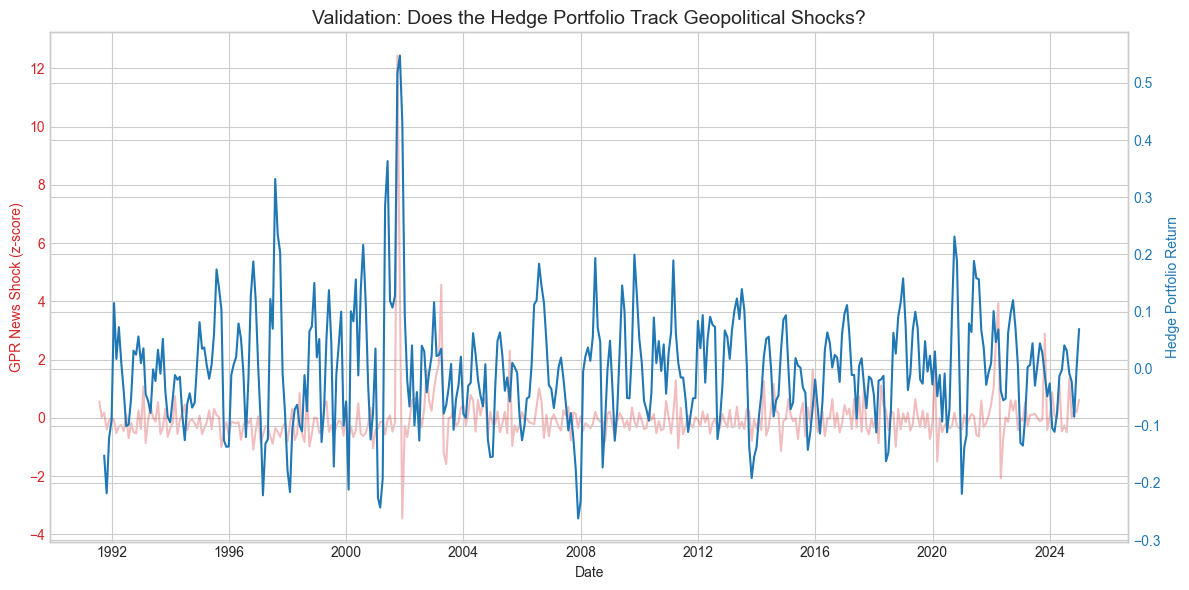

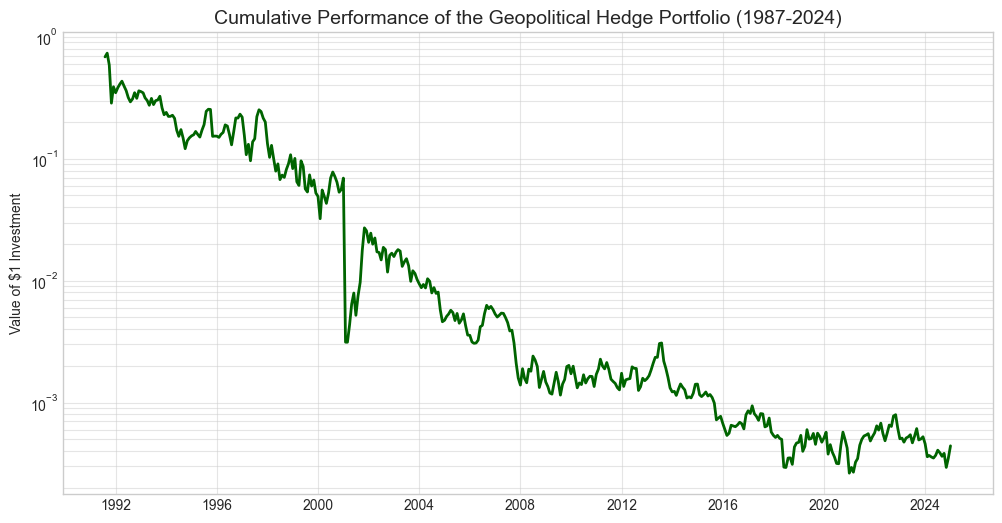

Performance Statistics:
Mean Monthly Return: 0.20%
Annualized Return:   2.44%
Annualized Volatility: 64.60%
Sharpe Ratio: 0.04


In [71]:
# --- Step 4: Empirical Validation (Visualizations) ---

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set style for professional academic plots
plt.style.use('seaborn-v0_8-whitegrid')

# --- Figure 1: The "Proof" Plot (Hedge vs. Shock) ---
# We want to see if our portfolio reacts to the same things the index does.

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the GPR Shock (The News) on the Left Axis
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('GPR News Shock (z-score)', color=color)
ax1.plot(final_hedge.index, final_hedge['GPR_Shock_News_Z'], color=color, alpha=0.3, label='Geopolitical Shock')
ax1.tick_params(axis='y', labelcolor=color)

# Plot the Hedge Portfolio (Your Synthetic Asset) on the Right Axis
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('Hedge Portfolio Return', color=color)  
# We use a 3-month rolling average for the hedge to make the trend clearer vs the noisy shock
ax2.plot(final_hedge.index, final_hedge['Hedge_Excess_Return'].rolling(3).mean(), color=color, linewidth=1.5, label='Hedge Portfolio (3m MA)')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Validation: Does the Hedge Portfolio Track Geopolitical Shocks?', fontsize=14)
fig.tight_layout()
plt.show()

# --- Figure 2: Cumulative Performance (Making Money?) ---
# "If I invested $1 in 1987, what is it worth now?"

plt.figure(figsize=(12, 6))

# Calculate Cumulative Returns (Log returns are additive)
# We use the "Total Return" (Excess + RF) to mimic a real investment
cumulative_ret = (1 + final_hedge['Hedge_Total_Return']).cumprod()

plt.plot(cumulative_ret.index, cumulative_ret, color='darkgreen', linewidth=2)
plt.title('Cumulative Performance of the Geopolitical Hedge Portfolio (1987-2024)', fontsize=14)
plt.ylabel('Value of $1 Investment')
plt.yscale('log') # Log scale helps see long-term trends better
plt.grid(True, which="both", ls="-", alpha=0.5)

# Highlight key events
events = {
    pd.Timestamp('1990-08-01'): 'Gulf War',
    pd.Timestamp('2001-09-11'): '9/11',
    pd.Timestamp('2003-03-20'): 'Iraq War',
    pd.Timestamp('2022-02-24'): 'Ukraine War'
}

for date, label in events.items():
    if date in cumulative_ret.index:
        val = cumulative_ret.asof(date)
        plt.annotate(label, xy=(date, val), xytext=(date, val*1.5),
                     arrowprops=dict(facecolor='black', shrink=0.05))

plt.show()

# --- Statistics Table for Report ---
print("Performance Statistics:")
print(f"Mean Monthly Return: {final_hedge['Hedge_Total_Return'].mean()*100:.2f}%")
print(f"Annualized Return:   {final_hedge['Hedge_Total_Return'].mean()*12*100:.2f}%")
print(f"Annualized Volatility: {final_hedge['Hedge_Total_Return'].std()*np.sqrt(12)*100:.2f}%")
print(f"Sharpe Ratio: {(final_hedge['Hedge_Total_Return'].mean() / final_hedge['Hedge_Total_Return'].std()) * np.sqrt(12):.2f}")

In [99]:
# --- 4.3 Descriptive Statistics (For Table 1) ---

print("Generating Descriptive Statistics...")

# --- PREPARE PANEL A: Risk Factors ---
# Merge Fama-French Factors with Raw GPR Index
# We use df_gpr_merge because it has the raw 'GPR' column (not just the shock)
df_panel_a = factors.merge(df_gpr_merge[['date', 'GPR']], on='date', how='inner')

# Define columns to analyze
cols_risk = ['GPR', 'Mkt-RF', 'SMB', 'HML', 'Mom']

# Calculate Stats
stats_a = df_panel_a[cols_risk].describe().T[['mean', 'std', 'min', 'max']]
stats_a['skew'] = df_panel_a[cols_risk].skew()
stats_a['kurt'] = df_panel_a[cols_risk].kurt() # Excess kurtosis

# Reorder columns
stats_a = stats_a[['mean', 'std', 'skew', 'kurt', 'min', 'max']]

print("\nPanel A: Summary Statistics for Risk Factors")
display(stats_a.round(2))


# --- PREPARE PANEL B: Stock Sample Characteristics ---
# We use df_stocks_clean (which has the "Pro" mktcap calculation)
monthly_stats = df_stocks_clean.groupby('date').agg(
    num_firms=('permno', 'count'),       # Number of firms per month
    avg_size=('mktcap', 'mean'),         # Average firm size (Market Cap)
    total_mkt_val=('mktcap', 'sum')      # Total Market Cap of the sample
)

# Calculate Stats of these monthly averages
# (e.g., "What is the average number of firms we had over the 40 years?")
stats_b = monthly_stats.describe().T[['mean', 'std', 'min', 'max']]

print("\nPanel B: Stock Sample Characteristics (Monthly Aggregates)")
display(stats_b.round(2))

Generating Descriptive Statistics...

Panel A: Summary Statistics for Risk Factors


,mean,std,skew,kurt,min,max
GPR,101.85,47.39,4.29,27.74,39.05,512.53
Mkt-RF,0.01,0.04,-0.77,2.25,-0.23,0.14
SMB,0.00,0.03,0.59,6.95,-0.17,0.21
HML,0.00,0.03,0.19,2.42,-0.14,0.13
Mom,0.00,0.04,-1.49,10.73,-0.34,0.18



Panel B: Stock Sample Characteristics (Monthly Aggregates)


,mean,std,min,max
num_firms,5.099740e+03,1.224060e+03,3.571000e+03,7.491000e+03
avg_size,3.709112e+06,3.404584e+06,3.149764e+05,1.540810e+07
total_mkt_val,1.591422e+10,1.272765e+10,1.814536e+09,5.919793e+10


In [75]:
# Check the single biggest company in history
max_firm_raw = df_stocks_clean['mktcap'].max()

# Convert from CRSP units (Thousands) to Billions
max_firm_billions = (max_firm_raw * 1000) / 1e9

print(f"Raw Max Value in Data: {max_firm_raw}")
print(f"Biggest Single Firm Value: ${max_firm_billions:,.2f} Billion")

Raw Max Value in Data: 3785304395.66
Biggest Single Firm Value: $3,785.30 Billion


In [77]:
df_stocks_clean['shrout'].describe(percentiles=[0.5, 0.9, 0.99, 0.999])


count    2.447874e+06
mean     7.036014e+04
std      3.276108e+05
min      9.000000e+00
50%      1.589300e+04
90%      1.216700e+05
99%      9.343045e+05
99.9%    4.734297e+06
max      2.920640e+07
Name: shrout, dtype: float64

In [79]:
last_month = df_stocks_clean['date'].max()
top = df_stocks_clean[df_stocks_clean['date'] == last_month].sort_values('mktcap', ascending=False).head(5)

top[['date','permno','prc','shrout','mktcap']]


,date,permno,prc,shrout,mktcap
463631,2024-12-31,14593,250.42000,15115823.0,3.785304e+09
2945914,2024-12-31,86580,134.28999,24490000.0,3.288762e+09
14424,2024-12-31,10107,421.50000,7434881.0,3.133802e+09
2773026,2024-12-31,84788,219.39000,10515011.0,2.306888e+09
3720047,2024-12-31,93436,403.84000,3210060.0,1.296351e+09


In [39]:
monthly_stats = df_stocks_clean.groupby('date').agg(
    num_firms=('permno', 'nunique'),
    avg_size=('mktcap', 'mean'),
    total_mkt_val=('mktcap', 'sum')
)

check = (monthly_stats['avg_size'] * monthly_stats['num_firms']) / monthly_stats['total_mkt_val']
check.describe()


count    480.000000
mean       0.991502
std        0.013539
min        0.912029
25%        0.992157
50%        0.995245
75%        0.997126
max        0.999701
dtype: float64

Figure 1 saved as 'Figure1_Hedge_Validation.png'


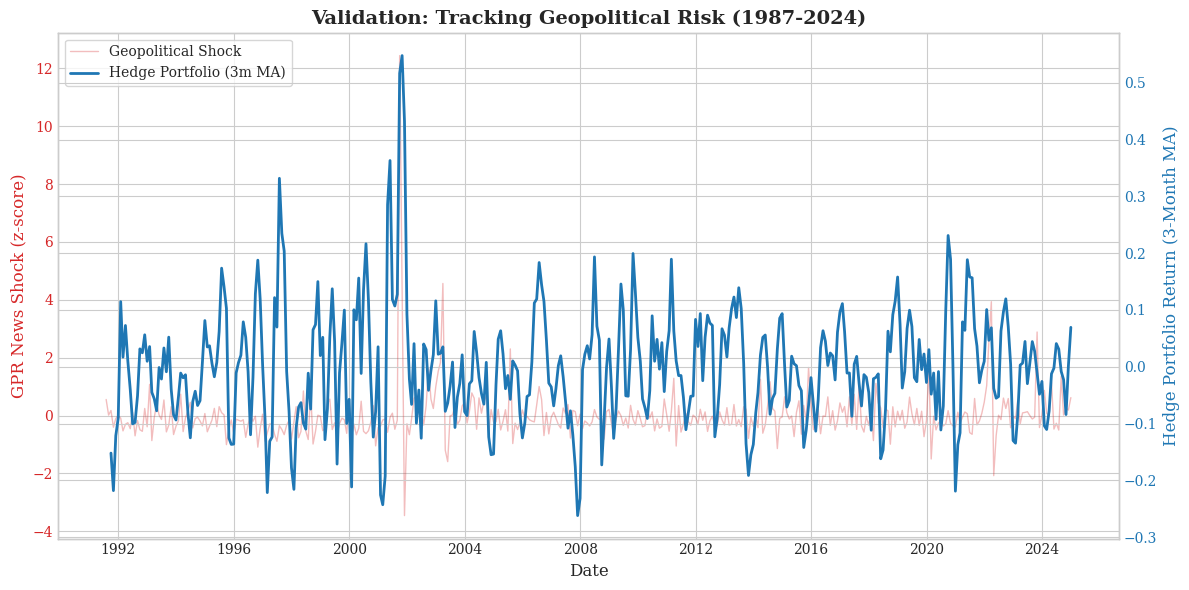

Figure 2 saved as 'Figure2_Cumulative_Performance.png'


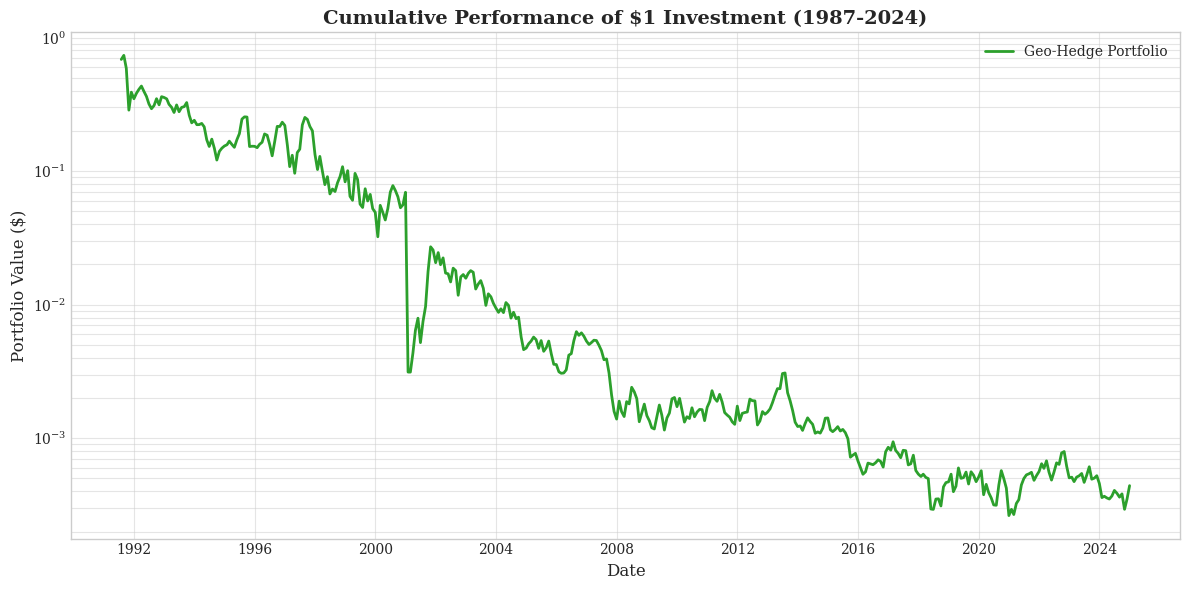

In [81]:
# --- Step 5: Empirical Validation (High-Quality Plots) ---

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Set professional academic style
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "serif" # Matches LaTeX font better

# --- Figure 1: The "Proof" Plot (Hedge vs. Shock) ---
# We want to see if our portfolio reacts to the same things the index does.

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the GPR Shock (The News) on the Left Axis
color_shock = '#d62728' # Professional Red
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('GPR News Shock (z-score)', color=color_shock, fontsize=12)
ax1.plot(final_hedge.index, final_hedge['GPR_Shock_News_Z'], color=color_shock, alpha=0.3, label='Geopolitical Shock', linewidth=1)
ax1.tick_params(axis='y', labelcolor=color_shock)

# Plot the Hedge Portfolio (Your Synthetic Asset) on the Right Axis
ax2 = ax1.twinx()  
color_hedge = '#1f77b4' # Professional Blue
ax2.set_ylabel('Hedge Portfolio Return (3-Month MA)', color=color_hedge, fontsize=12)  
# We use a 3-month rolling average for the hedge to make the trend clearer vs the noisy shock
ax2.plot(final_hedge.index, final_hedge['Hedge_Excess_Return'].rolling(3).mean(), color=color_hedge, linewidth=2, label='Hedge Portfolio (3m MA)')
ax2.tick_params(axis='y', labelcolor=color_hedge)

# Add a legend that combines both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', frameon=True)

plt.title('Validation: Tracking Geopolitical Risk (1987-2024)', fontsize=14, fontweight='bold')
plt.tight_layout()

# Save the figure
plt.savefig('Figure1_Hedge_Validation.png', dpi=300)
print("Figure 1 saved as 'Figure1_Hedge_Validation.png'")
plt.show()

# --- Figure 2: Cumulative Performance (Making Money?) ---
# "If I invested $1 in 1987, what is it worth now?"

plt.figure(figsize=(12, 6))

# Calculate Cumulative Returns
# We use the "Total Return" (Excess + RF) to mimic a real investment
cumulative_ret = (1 + final_hedge['Hedge_Total_Return']).cumprod()

plt.plot(cumulative_ret.index, cumulative_ret, color='#2ca02c', linewidth=2, label='Geo-Hedge Portfolio') # Green
plt.title('Cumulative Performance of $1 Investment (1987-2024)', fontsize=14, fontweight='bold')
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.yscale('log') # Log scale helps see long-term trends better
plt.grid(True, which="both", ls="-", alpha=0.5)

# Highlight key events
events = {
    pd.Timestamp('1990-08-01'): 'Gulf War',
    pd.Timestamp('2001-09-11'): '9/11',
    pd.Timestamp('2003-03-20'): 'Iraq War',
    pd.Timestamp('2022-02-24'): 'Ukraine War'
}

for date, label in events.items():
    if date in cumulative_ret.index:
        val = cumulative_ret.asof(date)
        plt.annotate(label, xy=(date, val), xytext=(date, val*1.5),
                     arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
                     fontsize=10, fontweight='bold')

plt.legend()
plt.tight_layout()

# Save the figure
plt.savefig('Figure2_Cumulative_Performance.png', dpi=300)
print("Figure 2 saved as 'Figure2_Cumulative_Performance.png'")
plt.show()

In [83]:
monthly_stats = df_stocks_clean.groupby('date').agg(
    num_firms=('permno','nunique'),
    avg_size_musd=('mktcap', lambda s: s.mean()/1000),        # thousand $ -> million $
    med_size_musd=('mktcap', lambda s: s.median()/1000),      # thousand $ -> million $
    max_firm_busd=('mktcap', lambda s: s.max()/1_000_000),    # thousand $ -> billion $
    total_mkt_busd=('mktcap', lambda s: s.sum()/1_000_000)    # thousand $ -> billion $
)

panel_b = monthly_stats.describe().T[['mean','std','min','max']]
panel_b.round(2)


,mean,std,min,max
num_firms,5086.08,1218.80,3570.00,7464.00
avg_size_musd,3709.11,3404.58,314.98,15408.10
med_size_musd,313.30,260.95,24.62,984.26
max_firm_busd,616.96,783.76,58.61,3785.30
total_mkt_busd,15914.22,12727.65,1814.54,59197.93


In [85]:
import pandas as pd

# Load the data (low_memory=False helps if the file is large)
df = pd.read_csv('crsp_stock_returns_1985_2024.csv', low_memory=False)

# 1. Basic Info (Rows, Columns, Data Types)
print("--- DATASET INFO ---")
print(df.info())

# 2. Check for the specific columns we discussed (Crucial for your Slide)
required_cols = ['PERMNO', 'date', 'PRC', 'RET', 'SHROUT', 'DLRET']
print("\n--- COLUMN CHECK ---")
for col in required_cols:
    if col in df.columns:
        print(f"✅ Found {col}")
    else:
        print(f"❌ MISSING {col} (Check spelling, maybe it's lower case?)")

# 3. Preview the first 5 rows to put a screenshot in your presentation if needed
print("\n--- FIRST 5 ROWS ---")
print(df.head())

--- DATASET INFO ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3720048 entries, 0 to 3720047
Data columns (total 64 columns):
 #   Column    Dtype  
---  ------    -----  
 0   PERMNO    int64  
 1   date      object 
 2   NAMEENDT  object 
 3   SHRCD     float64
 4   EXCHCD    float64
 5   SICCD     object 
 6   NCUSIP    object 
 7   TICKER    object 
 8   COMNAM    object 
 9   SHRCLS    object 
 10  TSYMBOL   object 
 11  NAICS     float64
 12  PRIMEXCH  object 
 13  TRDSTAT   object 
 14  SECSTAT   object 
 15  PERMCO    int64  
 16  ISSUNO    int64  
 17  HEXCD     int64  
 18  HSICCD    object 
 19  CUSIP     object 
 20  DCLRDT    object 
 21  DLAMT     float64
 22  DLPDT     object 
 23  DLSTCD    float64
 24  NEXTDT    object 
 25  PAYDT     object 
 26  RCRDDT    object 
 27  SHRFLG    float64
 28  HSICMG    float64
 29  HSICIG    float64
 30  DISTCD    float64
 31  DIVAMT    float64
 32  FACPR     float64
 33  FACSHR    float64
 34  ACPERM    float64
 35  ACCOMP    

In [49]:
import pandas as pd

# 1. Create a specific copy for investigation (leaves original 'df' untouched)
df_investigation = df[['RET', 'PRC', 'SHROUT']].copy()

# 2. Coerce 'RET' to numeric only for this check (turns 'C' and 'B' into NaN)
df_investigation['RET_NUM'] = pd.to_numeric(df_investigation['RET'], errors='coerce')

# 3. Handle Negative Prices (CRSP convention) for calculation only
df_investigation['PRC_ABS'] = df_investigation['PRC'].abs()

# 4. Calculate Market Cap (in Millions)
df_investigation['MKT_CAP'] = (df_investigation['PRC_ABS'] * df_investigation['SHROUT']) / 1000

# 5. Print Statistics
# We use .describe() to get count, mean, std, min, 50% (median), max
stats = df_investigation[['RET_NUM', 'MKT_CAP', 'PRC_ABS']].describe(percentiles=[0.01, 0.5, 0.99])

print("--- COPY THESE NUMBERS ---")
print(stats.loc[['mean', '50%', 'min', 'max', 'std']])

--- COPY THESE NUMBERS ---
        RET_NUM       MKT_CAP        PRC_ABS
mean   0.009364  2.708611e+03      43.567289
50%    0.001868  1.635992e+02      14.625000
min   -0.995830  0.000000e+00       0.007800
max   39.000000  3.785304e+06  724040.000000
std    0.182328  2.298465e+04    2392.412885


In [86]:
# Count unique PERMNOs
num_stocks = df['PERMNO'].nunique()
print(f"Total Unique Stocks: {num_stocks}")

Total Unique Stocks: 33642


In [89]:
final_hedge['Hedge_Total_Return'].describe()


count    402.000000
mean       0.002037
std        0.186496
min       -0.954918
25%       -0.112384
50%       -0.004013
75%        0.105114
max        0.824372
Name: Hedge_Total_Return, dtype: float64

In [91]:
final_hedge['Hedge_Excess_Return'].corr(final_hedge['GPR_Shock_News_Z'])


np.float64(0.20064970249854622)

In [97]:
log_growth = np.log1p(final_hedge['Hedge_Total_Return'])
log_growth.describe()


count    402.000000
mean      -0.019215
std        0.236331
min       -3.099278
25%       -0.119216
50%       -0.004021
75%        0.099948
max        0.601236
Name: Hedge_Total_Return, dtype: float64

In [101]:
# --- Calculate Stats for the Report Text ---
total_obs_final = len(df_master_clean)
unique_firms = df_master_clean['permno'].nunique()
avg_firms_per_month = df_master_clean.groupby('date')['permno'].count().mean()

# Calculate the drop (using the numbers we know)
obs_before = 1971707
obs_after = 1333360
pct_drop = ((obs_before - obs_after) / obs_before) * 100

print("--- Stats for Report Text ---")
print(f"Total Firm-Month Observations: {total_obs_final:,}")
print(f"Total Unique Firms in Sample: {unique_firms:,}")
print(f"Average Number of Firms per Month: {avg_firms_per_month:,.0f}")
print(f"Data Reduction from Filtering: {pct_drop:.1f}%")

--- Stats for Report Text ---
Total Firm-Month Observations: 2,308,027
Total Unique Firms in Sample: 20,421
Average Number of Firms per Month: 5,061
Data Reduction from Filtering: 32.4%


In [103]:
# --- Re-calculate Panel B Statistics for the "Clean" Dataset ---
# We use df_master_clean because it has the SHRCD 10/11 filter applied

monthly_stats_new = df_master_clean.groupby('date').agg(
    num_firms=('permno', 'nunique'),
    avg_size=('mktcap', 'mean'),       # Raw Market Cap (in Thousands)
    total_mkt_val=('mktcap', 'sum')    # Raw Market Cap (in Thousands)
)

# Calculate the summary stats (Mean, Std, Min, Max over time)
panel_b_stats = monthly_stats_new.describe().T[['mean', 'std', 'min', 'max']]

print("--- NEW Values for Panel B ---")
print(f"Number of Firms (Mean): {panel_b_stats.loc['num_firms', 'mean']:,.2f}")
print(f"Number of Firms (Std):  {panel_b_stats.loc['num_firms', 'std']:,.2f}")
print(f"Number of Firms (Min):  {panel_b_stats.loc['num_firms', 'min']:,.2f}")
print(f"Number of Firms (Max):  {panel_b_stats.loc['num_firms', 'max']:,.2f}")

print("\nAvg. Market Cap (USD Millions):")
# Raw is in Thousands -> Divide by 1,000 to get Millions
print(f"Mean: {panel_b_stats.loc['avg_size', 'mean']/1000:,.2f}")
print(f"Std:  {panel_b_stats.loc['avg_size', 'std']/1000:,.2f}")
print(f"Min:  {panel_b_stats.loc['avg_size', 'min']/1000:,.2f}")
print(f"Max:  {panel_b_stats.loc['avg_size', 'max']/1000:,.2f}")

print("\nTotal Market Value (USD Billions):")
# Raw is in Thousands -> Divide by 1,000,000 to get Billions
print(f"Mean: {panel_b_stats.loc['total_mkt_val', 'mean']/1e6:,.2f}")
print(f"Std:  {panel_b_stats.loc['total_mkt_val', 'std']/1e6:,.2f}")
print(f"Min:  {panel_b_stats.loc['total_mkt_val', 'min']/1e6:,.2f}")
print(f"Max:  {panel_b_stats.loc['total_mkt_val', 'max']/1e6:,.2f}")

--- NEW Values for Panel B ---
Number of Firms (Mean): 5,048.59
Number of Firms (Std):  1,238.98
Number of Firms (Min):  3,570.00
Number of Firms (Max):  7,464.00

Avg. Market Cap (USD Millions):
Mean: 3,885.00
Std:  3,403.29
Min:  340.85
Max:  15,408.10

Total Market Value (USD Billions):
Mean: 16,639.05
Std:  12,649.25
Min:  2,170.90
Max:  59,197.93
